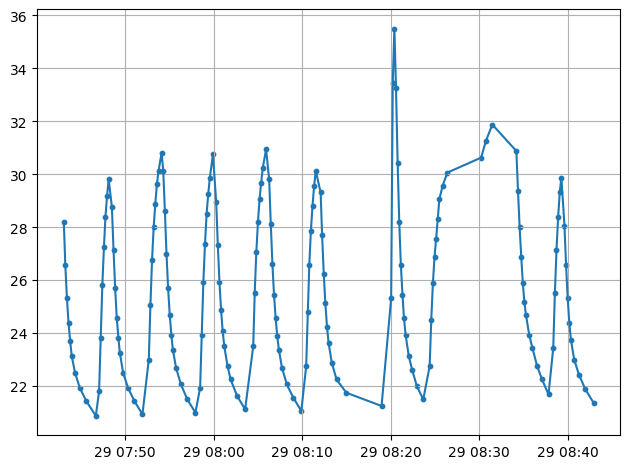

In [113]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("teplota_log.csv", header=None, names=["Time", "Value"])
df["Time"] = pd.to_datetime(df["Time"], errors="coerce")
df["Value"] = pd.to_numeric(df["Value"], errors="coerce")
df = df.dropna().sort_values("Time").drop_duplicates("Time")

df_plot = df[df["Time"] >= df["Time"].max() - pd.Timedelta(hours=1)]

plt.plot(df_plot["Time"], df_plot["Value"])
plt.scatter(df_plot["Time"], df_plot["Value"], s=10)
plt.grid()
plt.tight_layout()
plt.show()


In [114]:
print(df_plot[df_plot["Value"] < -5].head()) 
print(df_plot[df_plot["Value"] > 35].head())

Empty DataFrame
Columns: [Time, Value]
Index: []
                     Time  Value
23793 2026-01-29 08:20:25   35.5


In [115]:
import pandas as pd

path = "/Users/Marek/Library/Mobile Documents/com~apple~CloudDocs/Documents/GitHub/Teploty_kotle/Weather.csv"

# Přeskočíme prvních 5 řádků, kde nejsou data
df_netatmo = pd.read_csv(path, skiprows=5)

# Oprava názvů sloupců
df_netatmo.columns = ["timestamp", "time_str", "temperature", "humidity", "empty"]

# Odstranění prázdného sloupce
df_netatmo = df_netatmo.drop(columns=["empty"])

# Převod timestamp → datetime
df_netatmo["time_utc"] = pd.to_datetime(df_netatmo["timestamp"], unit="s")

# Převod textového času → datetime
df_netatmo["time_local"] = pd.to_datetime(df_netatmo["time_str"])

df_netatmo


,timestamp,time_str,temperature,humidity,time_utc,time_local
0,1767222150,2026/01/01 00:02:30,1.5,86,2025-12-31 23:02:30,2026-01-01 00:02:30
1,1767222450,2026/01/01 00:07:30,1.5,86,2025-12-31 23:07:30,2026-01-01 00:07:30
2,1767222750,2026/01/01 00:12:30,1.5,86,2025-12-31 23:12:30,2026-01-01 00:12:30
3,1767223050,2026/01/01 00:17:30,1.6,86,2025-12-31 23:17:30,2026-01-01 00:17:30
4,1767223350,2026/01/01 00:22:30,1.6,86,2025-12-31 23:22:30,2026-01-01 00:22:30
...,...,...,...,...,...,...
6936,1769425800,2026/01/28 12:10:00,2.6,95,2026-01-26 11:10:00,2026-01-28 12:10:00
6937,1769425800,2026/01/28 15:00:00,3.6,95,2026-01-26 11:10:00,2026-01-28 15:00:00
6938,1769425800,2026/01/28 18:10:00,2.2,95,2026-01-26 11:10:00,2026-01-28 18:10:00
6939,1769425800,2026/01/29 5:40:00,0.9,95,2026-01-26 11:10:00,2026-01-29 05:40:00


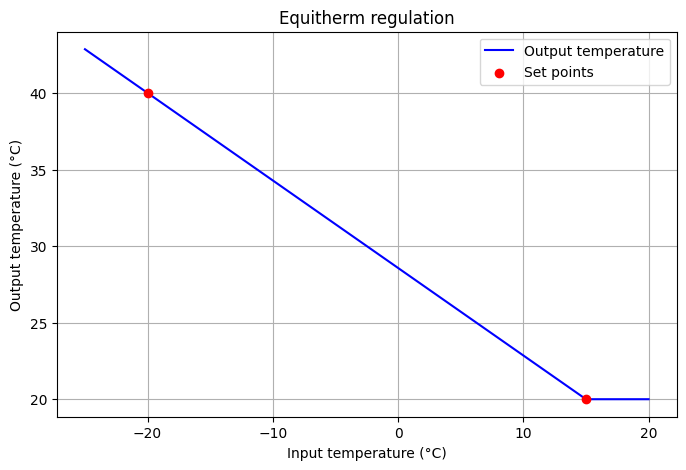

<Figure size 640x480 with 0 Axes>

In [116]:
import numpy as np
import matplotlib.pyplot as plt

# Správná lineární funkce
def hokejka(temp_in):
    if temp_in <= 15:
        return -0.571428 * temp_in + 28.5714
    else:
        return 20
    
# Data pro graf
temps_in = np.linspace(-25, 20, 200)
temps_out = [hokejka(t) for t in temps_in]

# Vykreslení
plt.figure(figsize=(8, 5))
plt.plot(temps_in, temps_out, label="Output temperature", color="blue")

# Body, které mají být přesně splněny
plt.scatter([-20, 15], [40, 20], color="red", zorder=15, label="Set points")

plt.title("Equitherm regulation")
plt.xlabel("Input temperature (°C)")
plt.ylabel("Output temperature (°C)")
plt.grid(True)
plt.legend()
plt.show()

# Uložení grafu
plt.savefig("Equit_graf.png")

In [117]:
import pandas as pd

# Přidáme sloupec Boiler_water
def hokejka(temp_in):
    if temp_in <= 15:
        return -0.571428 * temp_in + 28.5714
    else:
        return 20

df_netatmo["Boiler_water"] = df_netatmo["temperature"].apply(hokejka)

# Ukázka 10 řádků
df_netatmo.tail(10)

,timestamp,time_str,temperature,humidity,time_utc,time_local,Boiler_water
6931,1769425800,2026/01/27 06:20:00,1.0,95,2026-01-26 11:10:00,2026-01-27 06:20:00,27.999972
6932,1769425800,2026/01/27 13:50:00,3.5,95,2026-01-26 11:10:00,2026-01-27 13:50:00,26.571402
6933,1769425800,2026/01/27 18:10:00,1.1,95,2026-01-26 11:10:00,2026-01-27 18:10:00,27.942829
6934,1769425800,2026/01/28 3:10:00,-1.5,95,2026-01-26 11:10:00,2026-01-28 03:10:00,29.428542
6935,1769425800,2026/01/28 9:00:00,0.2,95,2026-01-26 11:10:00,2026-01-28 09:00:00,28.457114
6936,1769425800,2026/01/28 12:10:00,2.6,95,2026-01-26 11:10:00,2026-01-28 12:10:00,27.085687
6937,1769425800,2026/01/28 15:00:00,3.6,95,2026-01-26 11:10:00,2026-01-28 15:00:00,26.514259
6938,1769425800,2026/01/28 18:10:00,2.2,95,2026-01-26 11:10:00,2026-01-28 18:10:00,27.314258
6939,1769425800,2026/01/29 5:40:00,0.9,95,2026-01-26 11:10:00,2026-01-29 05:40:00,28.057115
6940,1769425800,2026/01/29 8:20:00,0.0,95,2026-01-26 11:10:00,2026-01-29 08:20:00,28.571400


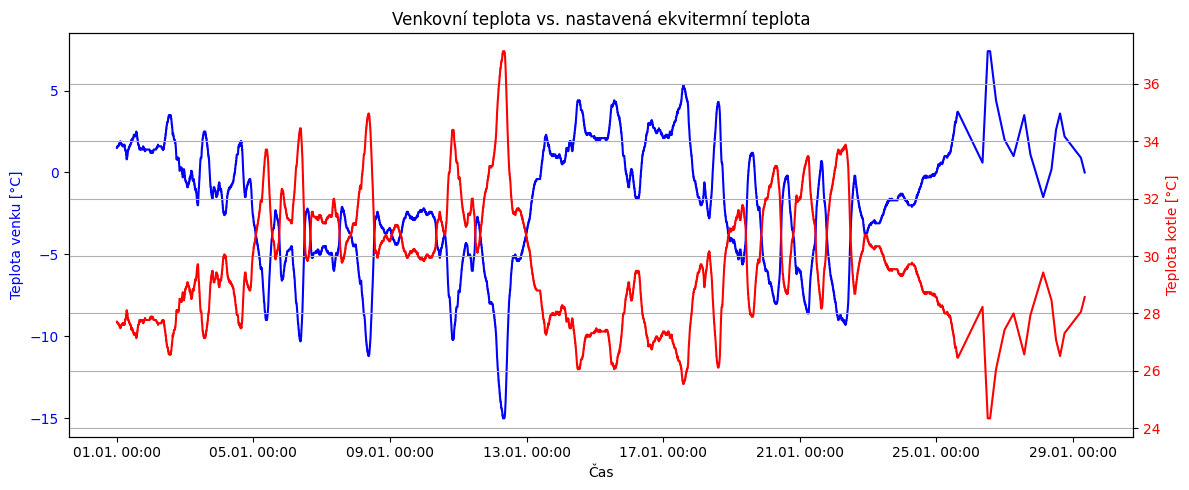

In [118]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

plt.figure(figsize=(12,5))

# Hlavní osa
ax = plt.gca()

# Venkovní teplota
ax.plot(df_netatmo["time_local"], df_netatmo["temperature"], color="blue") # marker="."
ax.set_ylabel("Teplota venku [°C]", color="blue")
ax.tick_params(axis="y", labelcolor="blue")

# Vedlejší osa (Boiler_water)
ax2 = ax.twinx()
ax2.plot(df_netatmo["time_local"], df_netatmo["Boiler_water"], color="red") # marker="."
ax2.set_ylabel("Teplota kotle [°C]", color="red")
ax2.tick_params(axis="y", labelcolor="red")

# Titulek a popisky
plt.title("Venkovní teplota vs. nastavená ekvitermní teplota")
ax.set_xlabel("Čas")

# Formátování osy X
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d.%m. %H:%M'))
plt.xticks(rotation=45)

plt.grid(True)
plt.tight_layout()
plt.show()

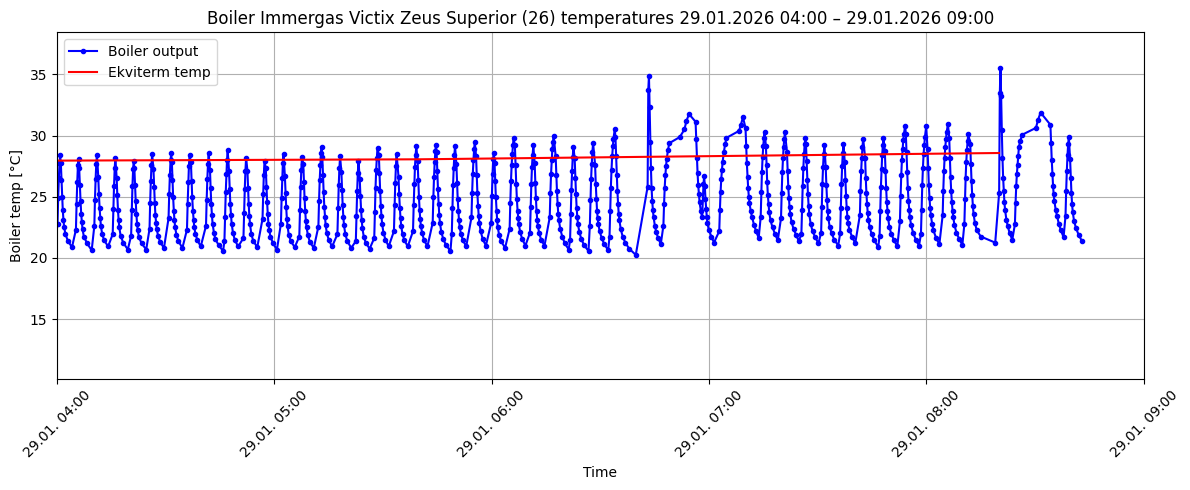

In [124]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd

# --- RUČNÍ NASTAVENÍ ČASOVÉHO OKNA ---
start_time = pd.Timestamp("2026-01-29 4:00:00")
end_time   = pd.Timestamp("2026-01-29 9:00:00")

plt.figure(figsize=(12,5))
ax = plt.gca()

# Kotel
ax.plot(df["Time"], df["Value"], marker=".", color="blue", label="Boiler output")

# Netatmo
ax.plot(df_netatmo["time_local"], df_netatmo["Boiler_water"], color="red", label="Ekviterm temp")

# --- APLIKACE ČASOVÉHO OKNA NA GRAF ---
ax.set_xlim(start_time, end_time)

# Formát osy X
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d.%m. %H:%M'))
plt.xticks(rotation=45)

plt.title(f"Boiler Immergas Victix Zeus Superior (26) temperatures {start_time:%d.%m.%Y %H:%M} – {end_time:%d.%m.%Y %H:%M}")

ax.set_xlabel("Time")
ax.set_ylabel("Boiler temp [°C]")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


/var/folders/px/7v29qw4j1fq7r7dx3wzzggyr0000gn/T/ipykernel_1813/3204442714.py:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_pradelna["cas"] = pd.to_datetime(df_pradelna["cas"], errors="coerce")


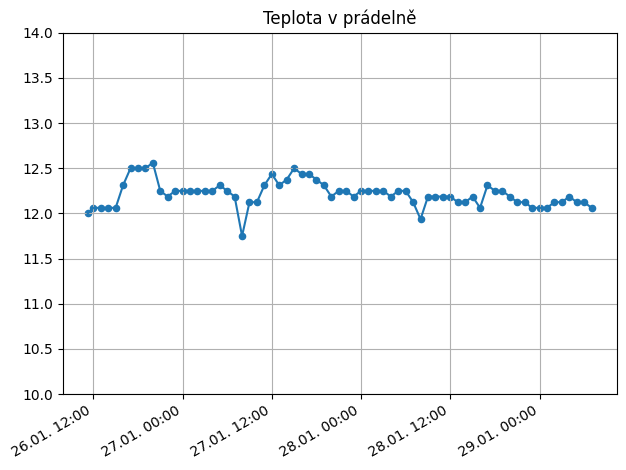

In [120]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

df_pradelna = pd.read_csv("teplota_pradelna.csv", header=None, names=["cas", "tepl"])
df_pradelna["cas"] = pd.to_datetime(df_pradelna["cas"], errors="coerce")
df_pradelna["tepl"] = pd.to_numeric(df_pradelna["tepl"], errors="coerce")
df_pradelna = df_pradelna.dropna().sort_values("cas").drop_duplicates("cas")

fig, ax = plt.subplots()

ax.set_ylim(10, 14)
ax.set_title("Teplota v prádelně")

ax.plot(df_pradelna["cas"], df_pradelna["tepl"])
ax.scatter(df_pradelna["cas"], df_pradelna["tepl"], s=20)

ax.grid()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d.%m. %H:%M'))
fig.autofmt_xdate()

plt.tight_layout()
plt.show()




In [121]:
df_pradelna

,cas,tepl
1,2026-01-26 11:15:44,12.000
2,2026-01-26 12:00:03,12.062
3,2026-01-26 13:00:03,12.062
4,2026-01-26 14:00:03,12.062
5,2026-01-26 15:00:03,12.062
...,...,...
65,2026-01-29 03:00:03,12.125
66,2026-01-29 04:00:03,12.187
67,2026-01-29 05:00:03,12.125
68,2026-01-29 06:00:03,12.125
